# Mooring Synthesis of Initial NC data (offline)

## 25BS-2A

- from netcdf files
- plot all depths of each parameter on each other for comparative purposes
- Temperature, Salinity, Pressure in this notebook.  See companion for Oxygen, Chlor, ADCP/currents, etc

In [16]:
import xarray as xa
import pandas as pd
import numpy as np
import cmocean

In [17]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


<Figure size 640x480 with 0 Axes>

In [32]:
ncfiles = '/Users/bell/ecoraid/2025/Moorings/25bs2a/final_data_cf/*.nc'
# ncfiles = '*.nc'
mfd = xa.open_mfdataset(ncfiles, chunks=None)


/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/dask/array/core.py:4996: PerformanceWarning: Increasing number of chunks 

## Hourly/Interpolated plots Plots

Because of the different timebases... quickly either interpolate (linearly) or downsample (this seems slower) to plot all series

In [33]:
mfd_hourly = mfd.chunk(dict(time=-1)).drop_indexes(['longitude','latitude']).interpolate_na("time")

ValueError: Only 1d and 2d plots are supported for facets in xarray. See the package `Seaborn` for more options.

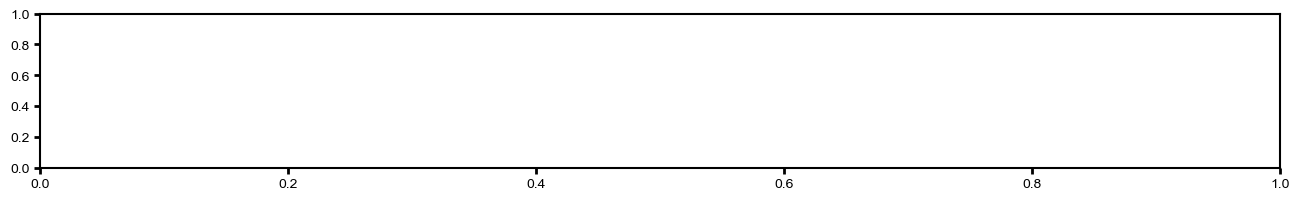

In [29]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_hourly.salinity.dropna(how='all',dim='depth').plot(x="time",hue="depth",ax=ax);

# ax.set_ylim([30.5,33.5])

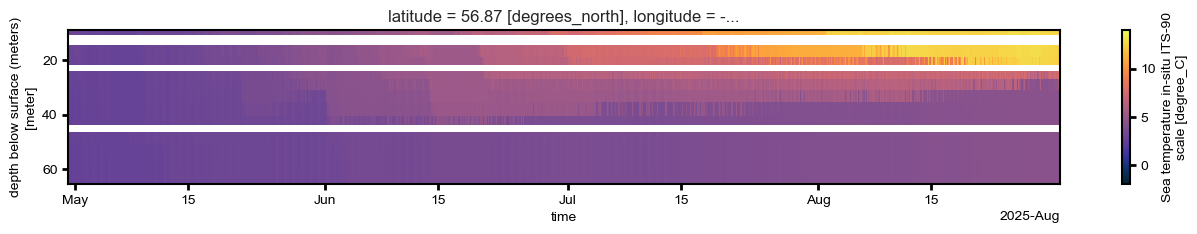

In [34]:
upper_temp = mfd_up.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_hourly.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=14,cmap=cmocean.cm.thermal)

## Chlorophyll Hourly Interpolated Plots

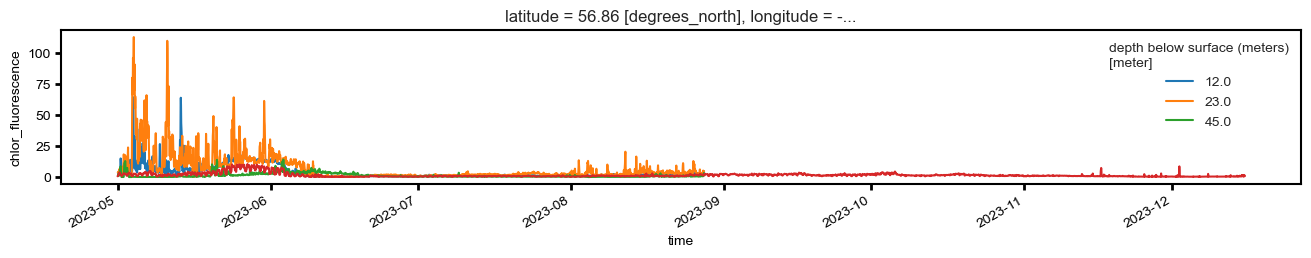

In [21]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.dropna(how='all',dim='depth').plot(x="time",hue="depth",ax=ax);
mfd_up_2.chlor_fluorescence.dropna(how='all',dim='depth').plot(x="time",hue="depth",ax=ax);
(mfd_up.isel({'depth':0}).chlor_fluorescence*0).plot(ax=ax,c='k',add_legend=False); #zeroline

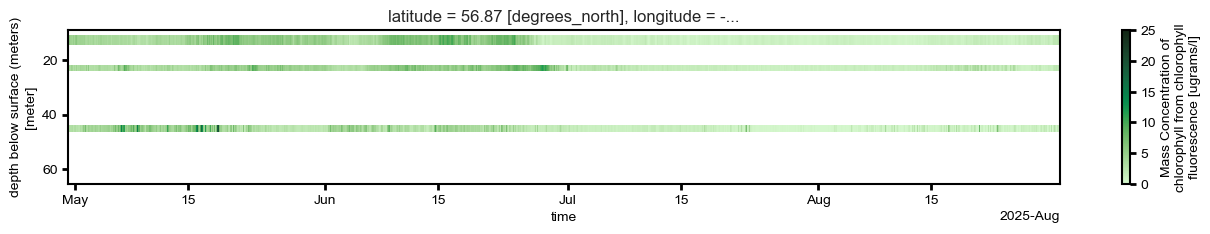

In [35]:
upper = 25
lower = 0

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_hourly.chlor_fluorescence.T.plot(ax=ax,yincrease=False,vmin=lower,vmax=upper,cmap=cmocean.cm.algae)

## Compare Timeseries to CTD Casts


- Recovery CTDXXX on Sikuliaq cruise, not yet obtained.

In [6]:
import EcoFOCIpy.io.erddap as erddap

In [8]:
dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2410',
               'qclevel':'preliminary',
               'concastno':'054'
              }

rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2504',
               'qclevel':'preliminary',
               'concastno':'000'
              }
               
depcast = erddap.erddapCTDretrieve(**dep_details)
# reccast = erddap.erddapCTDretrieve(**rec_details)

## QC Notes



(PJS needs to vet these)

## Generate to_edit files for PJS

- these are usually salinity focused and need the ctd casts as well as the salinity timeseries.
- save the native time scale, not the interpolated or upscaled version

In [13]:
with pd.ExcelWriter('25bs2a_salinity_to_edit.xlsx') as writer:  

    for depthkey in mfd.to_dataframe().salinity.groupby(level=[3]).groups.keys():
        if not (mfd.to_dataframe().salinity.groupby(level=[3]).get_group(depthkey).dropna(how='all')).empty:
            print(f'saving {depthkey}')
            (mfd.to_dataframe().salinity.groupby(level=[3]).get_group(depthkey).dropna(axis=0)).to_excel(writer, sheet_name=str(depthkey))

    depcast.to_excel(writer, sheet_name=depcast.profile_id.unique()[0])
    # reccast.to_excel(writer, sheet_name=reccast.profile_id.unique()[0])

saving 55.0
saving 65.0


In [15]:
with pd.ExcelWriter('25bs2a_temperature.xlsx') as writer:  

    for depthkey in mfd.to_dataframe().temperature.groupby(level=[3]).groups.keys():
        if not (mfd.to_dataframe().temperature.groupby(level=[3]).get_group(depthkey).dropna(how='all')).empty:
            print(f'saving {depthkey}')
            (mfd.to_dataframe().temperature.groupby(level=[3]).get_group(depthkey).dropna(axis=0)).to_excel(writer, sheet_name=str(depthkey))

    # depcast.to_excel(writer, sheet_name=depcast.profile_id.unique()[0])
    # reccast.to_excel(writer, sheet_name=reccast.profile_id.unique()[0])

saving 27.0
saving 31.0
saving 35.0
saving 40.0
saving 50.0
saving 55.0
saving 60.0
saving 65.0


In [12]:
mfd.to_dataframe().salinity.groupby(level=[3]).groups.keys()

dict_keys([27.0, 31.0, 35.0, 40.0, 50.0, 55.0, 60.0, 65.0])